# Laboratorio 3 - "Recepción de hipótesis enviadas a través del canal inhalámbrico"

### Alumno: Saillen, S

## Consigna:

El siguiente código genera una señal (hipótesis) binaria compleja que permite modificar, a través de la variable "ref", la probabilidad de ocurrencia de los valores binarios:

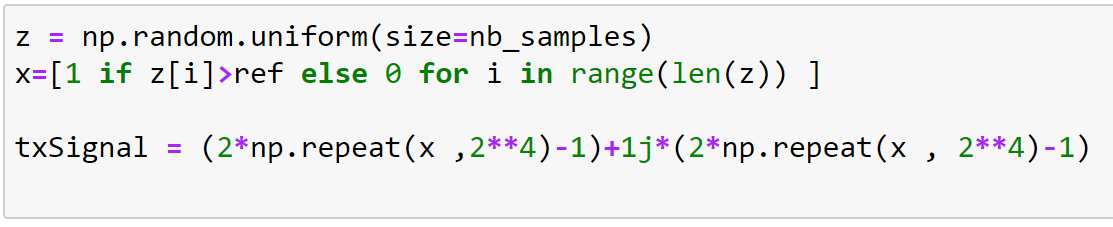

Inicialmente configure el valor de la variable "ref" a un valor de 0.5.

1. Realizar un gráfica temporal y el histograma de cada una de las componentes de la señal. Realizar también una gráfica en frecuencia. Describa con sus propias palabras lo que observa de las gráficas.

Considerando la siguiente configuración del SDR:

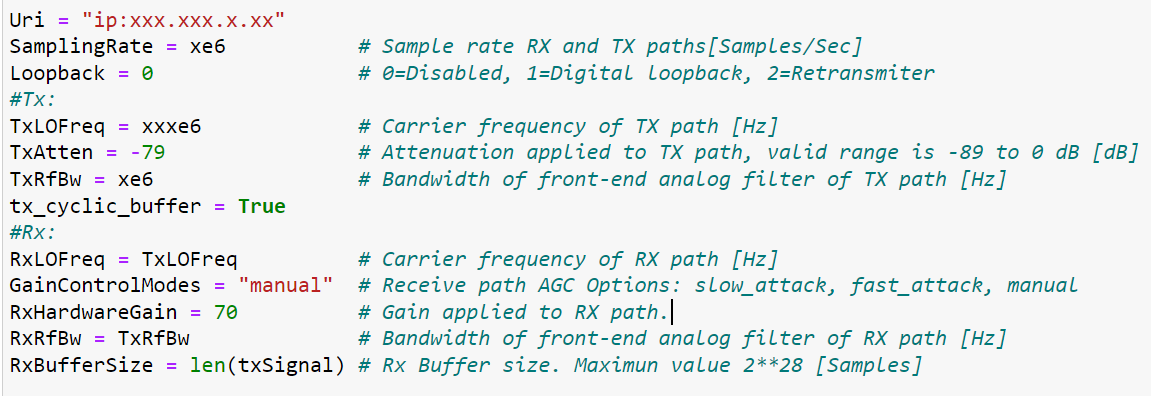

2. Realice una transmisión y recepción de la señal usando el SDR a través del medio inalámbrico. Normalice la señal recibida de forma tal que tenga potencia unitaria y realice una gráfica temporal y su correspondiente histograma tanto de la componente en fase como en cuadratura. Describa con sus propias palabras lo que observa de las gráficas. Tenga presente de realizar unas cuantas recepciones antes de obtener la recepción deseada cuando se usa el modo transmisión continua ("tx_cyclic_buffer = True"). Esto se hace para evitar capturar la señal en algún estado transitorio inicial y para eliminar del buffer del receptor muestras de señales tomadas con anterioridad. El siguiente código muestra el procedimiento descripto:

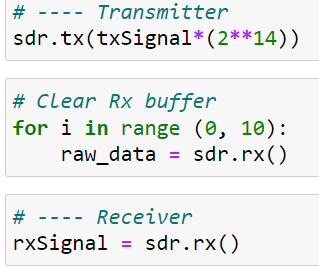

3. Repita los pasos anteriores pero ahora aumentando la potencia de la señal transmitida, esto es llevando el valor de la variable "TxAtten" al valor -70. Describa con sus propias palabras lo que observa en el histograma de la señal comparándola con lo anteriormente obtenido.

4. Configure el valor de la variable "ref" a un valor de 0.3 y repita los pasos anteriores. Que puede concluir del histograma obtenido de la señal recibida?

5. Modifique el código para enviar una hipotesis $H \in \{ -1,-0.3333,+0.3333,+1\}$ con igual probabilidades. Muestre el histograma de la señal recibida por el SDR. Describa con sus propias palabras lo que observa en la gráfica.

Tenga presente que si la cantidad de muestras de la señal a transmitir ha cambiado, debe eliminar el buffer Y volverlo a configurar para evitar errores de configuración. Las siguiente lineas de código muestra el procedimiento descripto:

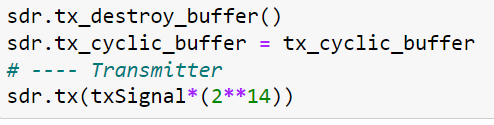


## Desarrollo:

### Configuraciones Previas

#### Imports

In [1]:
!pip install pyadi-iio

import adi
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm

Defaulting to user installation because normal site-packages is not writeable


#### Codigo Heredado

In [2]:
def plotSignal(signal):
#------------------------------- Transmitted I component ------------------------------- 
# Plot time domain
    plt.figure(figsize=(20,8), dpi= 80, facecolor='w', edgecolor='k')
    plt.subplot(2,1,1)
    plt.plot(np.real(signal))
    plt.xlabel('n')
    plt.ylabel('Amplitud')
    plt.title('Componente en fase de la señal')
    plt.grid()
#------------------------------- Transmitted Q component -------------------------------
# Plot time domain
    plt.subplot(2,1,2)
    plt.plot(np.imag(signal))
    plt.xlabel('n')
    plt.ylabel('Amplitud')
    plt.title('Componente en cuadratura de la señal')
    plt.grid()
    plt.show()

def plotSpect(signal,samplingRate):
    plt.subplots(figsize=(15, 3))
    plt.grid()
    plt.title("Power Spectral Density")
    plt.psd(signal, len(signal), samplingRate, color='C1')
    plt.show()

### 1. Realizar un gráfica temporal y el histograma de cada una de las componentes de la señal. Realizar también una gráfica en frecuencia. Describa con sus propias palabras lo que observa de las gráficas.

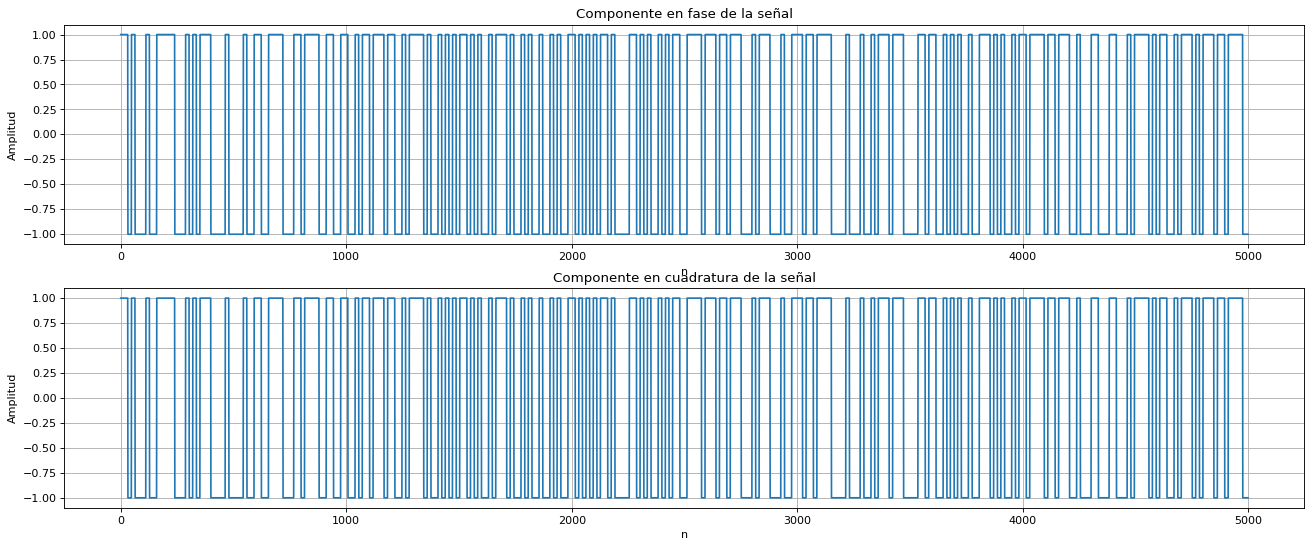

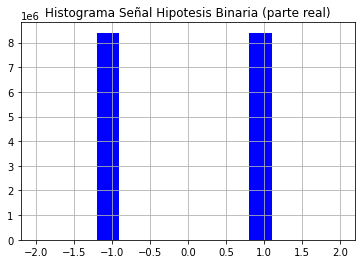

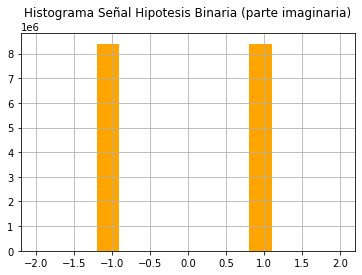

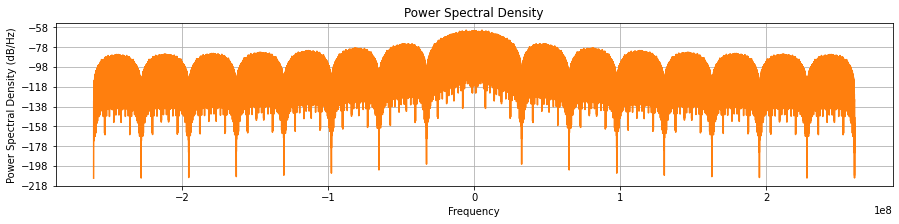

In [16]:
nb_samples = 2**20
ref = 0.5

z = np.random.uniform(size = nb_samples)
x = [1 if z[i] > ref else 0 for i in range(nb_samples)]

txSignal = (2*np.repeat(x, 2**4)-1) + 1j*(2*np.repeat(x, 2**4)-1)

# Grafica Temporal
plotSignal(txSignal[0:5000])

# Histogramas de cada Componente
plt.hist(np.real(txSignal), width = 0.3, color = "blue", range = (-2,2))
plt.title("Histograma Señal Hipotesis Binaria (parte real)")
plt.grid()
plt.show()

plt.hist(np.imag(txSignal), width = 0.3, color = "orange", range = (-2,2))
plt.title("Histograma Señal Hipotesis Binaria (parte imaginaria)")
plt.grid()
plt.show()

# Gráfica en Frecuencia
plotSpect(txSignal, 521e6)

**Observacion**: Como se puede observar en los graficos se está generando una señal de hipótesis binaria {0,1} de manera aleatoria con una probabilidad de fuente equiprobable, que es codificada en {-1,1} (como se ve en los graficos), por ende en el grafico de tiempo (que tuve que reducir la cantidad a mostrar para observar bien el comportamiento) se ve como una función cuadrada que va de valores {1,-1} conforme a la fuente. En el histograma se observa como la fuente es equiprobable. *En el grafico de frecuencia se observa como, debido a que la fuente genera aleatoriamente valores las frecuencias de la fuente generan varias armónicas concentricas a frecuencia 0.* (creo).

### 2. Realice una transmisión y recepción de la señal usando el SDR a través del medio inalámbrico. Normalice la señal recibida de forma tal que tenga potencia unitaria y realice una gráfica temporal y su correspondiente histograma tanto de la componente en fase como en cuadratura. Describa con sus propias palabras lo que observa de las gráficas.

*Tenga presente de realizar unas cuantas recepciones antes de obtener la recepción deseada cuando se usa el modo transmisión continua ("tx_cyclic_buffer = True"). Esto se hace para evitar capturar la señal en algún estado transitorio inicial y para eliminar del buffer del receptor muestras de señales tomadas con anterioridad.*

In [ ]:
#------------------------------- SDR Parameter Configuration -------------------------------

Uri              = "ip:192.168.1.35"
Loopback         = 0             # 0=Disabled, 1=Digital loopback, 2=Retransmiter
SamplingRate     = 521e6         # Sample rate RX and TX paths[Samples/Sec]                                 

TxLOFreq         = 954e6         # Carrier frequency of TX path [Hz]
TxAtten          = -79           # Attenuation applied to TX path, valid range is -89 to 0 dB [dB]
TxRfBw           = 2.0e6         # Bandwidth of front-end analog filter of TX path [Hz]
RxBufferSize     = 2**20         # Depend on the length of the transmit signal. Maximum tx buffer size 2**24[samples]
tx_cyclic_buffer = True

RxLOFreq         = TxLOFreq      # Carrier frequency of RX path [Hz]
GainControlModes = "manual"      # Receive path AGC Options: slow_attack, fast_attack, manual
RxHardwareGain   = 70            # Gain applied to RX path. Only applicable when gain_control_mode is set to 'manual'    
RxRfBw           = TxRfBw        # Bandwidth of front-end analog filter of RX path [Hz] 
RxBufferSize     = 2**20         # Rx Buffer size. Maximun value 2**28 [Samples]           